## Description

This notebook demonstrates complete facial emotion recognition pipeline, from photo to annotated image.
1. Facial detection is made with `dlib` library.
    * `dlib` uses CNN detector if GPU available, else fallbacks to HOG, which may give different results.
1. Facial emotion recognition is made with pretrained `tensorflow` CNN model.

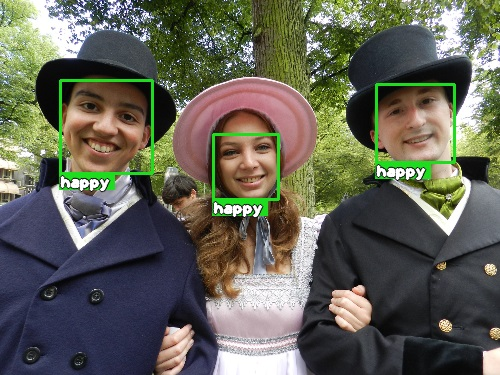

## Settings

In [ ]:
SAVED_MODEL_FER = 'saved_model_infr_fer.h5'

## Valence-arousal models currently are not used
# SAVED_MODEL_VALENCE = 'saved_model_infr_valence.h5'
# SAVED_MODEL_AROUSAL = 'saved_model_infr_arousal.h5'

## Downloads

In [ ]:
!gdown --id 1kg8gc6sg3wqm0TTg_6GI2yLEYzHBPZ0u  # 1.jpg
!gdown --id 11RPZABkt3T8pocgSzZZvQrn85q_GlPu5  # 2.jpg
!gdown --id 139hpFUxh9toyU0LwDq7mibYr6HjJgh6f  # saved_model_infr_fer.h5
# !gdown --id 1qqo7z4GnZ6-gtyyT_aVUKX7uaECXVUh8  # saved_model_infr_valence.h5
# !gdown --id 1zUQc_QEpFfV7wBTAlpzVMa5DnYQ03XX2  # saved_model_infr_arousal.h5

Downloading...
From: https://drive.google.com/uc?id=1kg8gc6sg3wqm0TTg_6GI2yLEYzHBPZ0u
To: /content/1.jpg
100% 88.0k/88.0k [00:00<00:00, 25.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=11RPZABkt3T8pocgSzZZvQrn85q_GlPu5
To: /content/2.jpg
100% 988k/988k [00:00<00:00, 65.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=139hpFUxh9toyU0LwDq7mibYr6HjJgh6f
To: /content/saved_model_infr_fer.h5
100% 1.19M/1.19M [00:00<00:00, 75.6MB/s]


In [ ]:
!ls -lAh {SAVED_MODEL_FER}

-rw-r--r-- 1 root root 1.2M Dec 11 09:11 saved_model_infr_fer.h5


In [ ]:
# CNN-based face detector files (if GPU is available)
from tensorflow.python.client import device_lib
has_gpu = any(d.device_type == 'GPU' for d in device_lib.list_local_devices())
if has_gpu:
    !wget https://github.com/davisking/dlib-models/raw/master/mmod_human_face_detector.dat.bz2
    !bunzip2 mmod_human_face_detector.dat.bz2

--2021-12-11 08:59:45--  https://github.com/davisking/dlib-models/raw/master/mmod_human_face_detector.dat.bz2
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/davisking/dlib-models/master/mmod_human_face_detector.dat.bz2 [following]
--2021-12-11 08:59:46--  https://raw.githubusercontent.com/davisking/dlib-models/master/mmod_human_face_detector.dat.bz2
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694687 (678K) [application/octet-stream]
Saving to: ‘mmod_human_face_detector.dat.bz2’

mmod_human_face_det 100%[===================>] 678.41K  --.-KB/s    in 0.05s   

2021-12-11 08:59:46 (12.8 MB/s) 

## Imports

In [ ]:
import warnings

from pathlib import Path

import numpy as np

import dlib
import cv2

from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf

## Definitions

In [ ]:
COLOR_GREEN = [30, 220, 30]
COLOR_RED = [220, 30, 30]
COLOR_WHITE = [255, 255, 255]
COLOR_GRAY = [200, 200, 200]
COLOR_BLACK = [30, 30, 30]

In [ ]:
#@title  { form-width: "1px" }
#@markdown ```python
#@markdown dlib_rects_to_numpy(dlib_rects)
#@markdown 
#@markdown draw_rects(img, rects, color=[0, 255, 0], thickness=1, inplace=False)
#@markdown 
#@markdown draw_text(
#@markdown     img, xy, text, font_face=cv2.FONT_HERSHEY_TRIPLEX,
#@markdown     font_scale=1, color=[0, 255, 0], thickness=1, anchor='top-left',
#@markdown     outline=0, outline_color=[0, 0, 0],
#@markdown     background_color=None, background_padding=(0, 0),
#@markdown     shift=(0, 0), line_spacing=1,
#@markdown     inplace=False)
#@markdown 
#@markdown crop_region(image, rect, expand=0, border_type=cv2.BORDER_REPLICATE)
#@markdown ```
def dlib_rects_to_numpy(dlib_rects):
    """Convert dlib rectangles object to numpy array, which
    allows to manipulate with coordinates more easily.
    
    Example:
    >>> dlib_rects
    rectangles[[(108, 165) (366, 423)], [(566, 194) (824, 452)]]
    >>> rects = dlib_rects_to_numpy(dlib_rects)
    >>> rects
    array([[[108, 165],    # left, top
            [366, 423]],   # right, bottom

        [[566, 194],
            [824, 452]]])
    >>> rects[:, 0]  # top-left corners
    array([[108, 165],
        [566, 194]])
    >>> rects[:, [1, 0], [0, 1]]
    array([[366, 165],  # top-right corners
        [824, 194]])
    >>> rects[:, [0, 1], [0, 1]]
    array([[108, 423],  # bottom-left corners
        [566, 452]])
    >>> rects.reshape(-1, 4)  # convert rects to 4-numbered tuples
    array([[108, 165, 366, 423],   # left, top, right, bottom
        [566, 194, 824, 452]])
    >>> np.rint(rects * 0.25).astype(int)  # downscale coordinates to 25%
    """
    if type(dlib_rects) == dlib.mmod_rectangles:
        dlib_rects = [mmod_rect.rect for mmod_rect in dlib_rects]
    nested_lists = [[[rect.left(), rect.top()], [rect.right(), rect.bottom()]]
                    for rect in dlib_rects]
    return np.array(nested_lists)


def draw_rects(img, rects, color=[0, 255, 0], thickness=1, inplace=False):
    if not inplace:
        img = img.copy()
    for [(x1, y1), (x2, y2)] in rects:
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)  # tuples are mandatory
    if not inplace:
        return img


def draw_text(img, xy, text, font_face=cv2.FONT_HERSHEY_COMPLEX,
    font_scale=1, color=[0, 255, 0], thickness=1, anchor='top-left',
    outline=0, outline_color=[0, 0, 0],
    background_color=None, background_padding=(0, 0),
    shift=(0, 0), line_spacing=1, line_type=0,
    inplace=False):
    """
    anchor : {'top-left', 'bottom-left'}
        Should `xy` be interpreted as top-left or bottom-left corner of the text.
        `cv2.putText()` uses bottom-left anchor by default.
    """
    if anchor != 'top-left':
        raise NotImplementedError

    if not inplace:
        img = img.copy()

    inner_thickness = thickness
    outer_thickness = thickness + outline

    lw, lh = cv2.getTextSize(text, font_face, font_scale, outer_thickness)[0]
    x0, y0 = xy
    dx, dy = shift
    x = x0 + dx
    y = y0 + dy

    lines = text.splitlines()
    if background_color is not None:
        max_w = 0
        tot_h = (len(lines) - 1) * line_spacing
        for line in lines:
            tw, th = cv2.getTextSize(line, font_face, font_scale, outer_thickness)[0]
            max_w = max(max_w, tw)
            tot_h += th
        pad_w, pad_h = background_padding
        cv2.rectangle(img, (x - pad_w, y - pad_h),
                      (x + max_w + pad_w, y + tot_h + pad_h),
                      background_color, -1)
    
    for line in text.splitlines():
        y += lh
        put_text_args = (img, line, (x, y), font_face, font_scale)
        if outline > 0:
            cv2.putText(*put_text_args, outline_color, outer_thickness, line_type)
        cv2.putText(*put_text_args, color, inner_thickness, line_type)
        y += line_spacing

    if not inplace:
        return img


def crop_region(image, rect, expand=0, border_type=cv2.BORDER_REPLICATE):
    """Returns a crop from the image given [[x1, y1], [x2, y2]] coordinates of
    two corners of the bounding rectangle. Right and bottom edges are not included.
    If coordinates (including `expand`) is out of bounds of the image, crop will
    be padded to match the rect size.
    
    Specific values for rect coordinates may lead to 0-sized crop. When trying
    to show with PIL (`PIL.Image.fromarray(crop)`) error will be raised:
    `ValueError: tile cannot extend outside image`.

    Due to bug in `cv2.copyMakeBorder` output dtype may differ from input dtype
    (int64 -> int32).

    image : array
        Shape (h, w, c) or (h, w) with height and width in first two dimentions.
    rect : array
        [[x1, y1], [x2, y2]]
    expand : int
        Expand crop to each side by n pixels.
    border_type : int
        `border_type` parameter for `cv2.copyMakeBorder` function. Has no effect
        if no padding needed. By default replicates the last row/column of pixels
        to make paddings.
        See https://docs.opencv.org/4.5.3/d3/df2/tutorial_py_basic_ops.html
        "Making Borders for Images (Padding)" for details about other
        `cv2.BORDER_...` options.

    Returns:
        Slice (a view) of input image array.

    Examples:

    >>> a = np.arange(9, dtype=np.int64).reshape(3, 3)
    >>> a
    array([[0, 1, 2],
           [3, 4, 5],
           [6, 7, 8]])

    >>> crop_region(a, [[0, 0], [2, 2]])
    array([[0, 1],
           [3, 4]], dtype=int32)
    
    >>> crop_region(a, [[0, 0], [2, 2]], expand=2)
    array([[0, 0, 0, 1, 2, 2],
           [0, 0, 0, 1, 2, 2],
           [0, 0, 0, 1, 2, 2],
           [3, 3, 3, 4, 5, 5],
           [6, 6, 6, 7, 8, 8],
           [6, 6, 6, 7, 8, 8]], dtype=int32)
    """
    [[x1, y1], [x2, y2]] = rect
    x1, x2 = sorted([x1, x2])
    y1, y2 = sorted([y1, y2])

    x1 -= expand
    y1 -= expand
    x2 += expand
    y2 += expand

    img_h, img_w = image.shape[:2]

    left, left_pad = (0, -x1) if x1 < 0 else (x1, 0)
    top, top_pad = (0, -y1) if y1 < 0 else (y1, 0)
    right, right_pad = (img_w, x2 - img_w) if x2 > img_w else (x2, 0)
    bottom, bottom_pad = (img_h, y2 - img_h) if y2 > img_h else (y2, 0)

    crop = image[top : bottom, left : right, ...]
    if crop.shape[0] > 0 and crop.shape[1] > 0:
        crop = cv2.copyMakeBorder(crop, top_pad, bottom_pad, left_pad, right_pad,
                                  cv2.BORDER_REPLICATE)
    return crop

In [ ]:
#@title  { form-width: "1px" }
#@markdown ```python
#@markdown FaceDetector(mode='auto', cnn_model_path='mmod_human_face_detector.dat', upsample_num=0)
#@markdown ```
class FaceDetector:
    """Detecting faces in the images using dlib library.

    Supported image formats:
        1. RGB: uint8 array of shape (h, w, 3)
        2. Gray: uint8 array of shape (h, w)

    Detected faces are represented with coordinates of the rectangular bounding
    boxes -- rects. Rects format:
        rects = [rect1, rect2, ...]  # can be empty if no faces were detected
        rect = [point1, point2]      # top-left and bottom-right corners
        point = [x, y]
        x: int  # offset from the left edge of the image (pixels column's index)
        y: int  # offset from the top edge of the image (pixels row's index)

    Parameters:
    -----------
    mode : {'auto', 'cpu', 'gpu'}
        cpu -- use HOG based detector.
        gpu -- use CNN based detector (required file "mmod_human_face_detector.dat").
        auto -- use CNN based detector if GPU available, else fallback to HOG.

    upsample_num : int
        Integer number >= 0. Image upsampling gives better detection quality,
        but multiplies time and memory costs.
    """
    def __init__(self, mode='auto', cnn_model_path='mmod_human_face_detector.dat', upsample_num=0):
        self.mode = mode
        self.upsample_num = upsample_num
        self._mode = None
        self.detector = None

        file_exists = False if cnn_model_path is None else Path(cnn_model_path).exists()
        if not file_exists and mode == 'gpu':
            raise FileNotFoundError(
                f'File not found: "{cnn_model_path}". Download archive with'
                f' `wget http://dlib.net/files/mmod_human_face_detector.dat.bz2`'
                f' and extract with `bunzip2 mmod_human_face_detector.dat.bz2`')
        
        if mode == 'gpu':
            self._mode = 'gpu'
        elif mode == 'cpu':
            self._mode = 'cpu'
        elif mode == 'auto':
            if file_exists:
                try:
                    dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")
                    self._mode = 'gpu'
                except RuntimeError as e:
                    # Error while calling cudaGetDevice(&the_device_id) in file
                    # /tmp/pip-wheel-mmuzni47/dlib/dlib/cuda/gpu_data.cpp:201. code: 100,
                    # reason: no CUDA-capable device is detected
                    
                    # Use HOG detector if no GPU available
                    self._mode = 'cpu'
                    print('Fallback to CPU: no CUDA-capable device is detected')
            else:
                self._mode = 'cpu'
                print('Fallback to CPU: "mmod_human_face_detector.dat" file not found')
        else:
            raise ValueError(f"Expected mode 'auto', 'cpu' or 'gpu', got: '{mode}'")

        if self._mode == 'cpu':
            self.detector = dlib.get_frontal_face_detector()
        elif self._mode == 'gpu':
            self.detector = dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")
        else:
            raise RuntimeError(f'Unexpected value for `self._mode`: "{self._mode}"')

    @staticmethod
    def draw_rects(image, rects):
        for rect in rects:
            [[x1, y1], [x2, y2]] = rect
            cv2.rectangle(image, (x1, y1), (x2, y2), [0, 255, 0], 1)
        return image

    def detect_faces(self, image):
        """
        image : array
            RGB or gray 8bit image.
        """
        dlib_rects = self.detector(image, self.upsample_num)
        rects = dlib_rects_to_numpy(dlib_rects)
        return rects

    def mark_faces(self, image, scale=(1, 1), callback=None, inplace=False):
        """
        image : array
            RGB or gray 8bit image.

        scale : (fx, fy)
            Resize image and scale rect coordinates accordingly.

        callback : function(image, rects) -> image
            Function will be called after the scaling. Intended for image
            annotation.

            image : array
                `image` if `inplace`, else `image.copy()`
            rects : array
                Rectangles -- one per detected face.

            Return
                Modified image.
        """
        if callback is None:
            callback = self.draw_rects
        assert callable(callback), '`callback` expected to be callable.'

        rects = self.detect_faces(image)

        if scale != (1, 1):
            image = cv2.resize(image, None, None, *scale)
            if len(rects) > 0:
                rects = np.rint(rects * scale).astype(int)

        if not inplace:
            image = image.copy()
        image = callback(image, rects)
        if not inplace:
            return image

In [ ]:
#@title  { form-width: "1px" }
#@markdown ```python
#@markdown ModelFer(saved_model_path)
#@markdown ```
class ModelFer:
    """Model for Facial Expression Recognition
    
    Classifies given image(s) of a face into one of the 9 categories: anger,
    contempt, disgust, fear, happy, neutral, sad, surprise and uncertain.

    Input format:
        * dtype: uint8
        * values range: [0, 255]
        * shape:
            * (h, w, c) -- single image input for `predict()`
            * (b, h, w, c) -- (b=batch_size) batch input for `predict_batch()`
        * c=channels: 1 or 3
            * c=1 -- for grayscale images
            * c=3 -- for RGB images (will be converted to grayscale)

    Grayscale images without channel dimention is not supported, i.e. arrays
    with shapes (h, w) or (b, h, w) are not valid inputs.
    """
    def __init__(self, saved_model_path):
        self.model = tf.keras.models.load_model(saved_model_path)

    @staticmethod
    def assert_batch_images_shape(images):
        if images.ndim == 4 and images.shape[-1] in [1, 3]:
            pass
        else:
            raise ValueError(
                f'Expected `images.shape` in [(b, h, w, 3), (b, h, w, 1)],'
                f' got: {images.shape}')

    @classmethod
    def preprocess(cls, images):
        """Preprocess batch of images for input.
        
        Valid input:
        1. shape: (b, h, w, {1, 3})
        2. dtype: uint8 or float32
        3. values range: [0, 255]

        Output:
        1. shape: (b, 128, 128, 1)
        2. dtype: uint8
        3. values range: [0, 255]
        """
        cls.assert_batch_images_shape(images)

        n_channels = images.shape[-1]
        raw_images = images

        # RGB to grayscale if needed: (b, h, w, 3) -> (b, h, w, 1)
        if n_channels == 3:
            images = tf.image.rgb_to_grayscale(images).numpy()

        # Resize if needed
        (in_h, in_w, in_c) = (128, 128, 1)  # model_input_size -- can be read from `model.input`
        (b, h, w, c) = images.shape  # actual size

        if in_h != h or in_w != w:
            images = tf.image.resize(images, (in_h, in_w)).numpy()  # returns float32
            images = images.astype(np.uint8)                        # float32 -> uint8

        assert (images.shape == (b, in_h, in_w, in_c)
                and images.dtype == np.uint8), 'This function has a bug. Check the code.'
        return images


    @staticmethod
    def decode_preds(preds):
        class_names = np.array(['anger', 'contempt', 'disgust', 'fear', 'happy',
                             'neutral', 'sad', 'surprise', 'uncertain'])
        return class_names[preds.argmax(axis=1)]


    def predict_batch(self, images):
        """Convinience function that: (1) verifies format and prepares images for
            inference, (2) calls `model.predict()`, (3) decodes predictions.

        images : array
            Batch of images in form of 4D uint8 array.
        """
        assert images.dtype == np.uint8, f'got {images.dtype}'

        if images.ndim == 3:
            raise ValueError(
                f'Expected batch input, got: {images.shape}. For single image'
                f' input use `predict()` method.')
        
        raw_images = images
        images = self.preprocess(raw_images)

        preds = self.model.predict(images)
        classes = self.decode_preds(preds)
        return classes


    def predict(self, image):
        """
        image : array
            Gray or RGB 8bit image in form of 2D or 3D uint8 array.
        """
        assert image.dtype == np.uint8, f'got {image.dtype}'

        if image.ndim == 4:
            raise ValueError(
                f'Expected single image input, got: {image.shape}. For batch'
                f' input use `predict_batch()` method.')
        batch = image[None, ...]
        class_name, = self.predict_batch(batch)
        return class_name

## Demo

In [ ]:
img1 = cv2.imread('1.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

img2 = cv2.imread('2.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

In [ ]:
detector = FaceDetector()
model_fer = ModelFer(SAVED_MODEL_FER)

Fallback to CPU: "mmod_human_face_detector.dat" file not found


In [ ]:
def annotate_facial_expressions(image, rects):
    crop_size = (128, 128)

    # Crop image regions with detected faces and concatenate them into a batch
    crops = []
    valid_rects = []
    for rect in rects:
        crop = crop_region(image, rect, expand=30)
        crop_h, crop_w = crop.shape[:2]
        if crop_h == 0 or crop_w == 0:
            # Invalid zero-sized crop
            continue
        crop = cv2.resize(crop, crop_size)
        crops.append(crop)
        valid_rects.append(rect)

    batch = np.array(crops)

    if len(batch) == 0:
        draw_text(image, (0, 0), 'No faces detected.\nTry increase image size.',
                  color=COLOR_WHITE, font_face=1, outline=2, thickness=2,
                  shift=(0, 0), background_color=COLOR_RED, background_padding=(1, 2),
                  line_type=16, inplace=True, line_spacing=3)
        return image

    class_names = model_fer.predict_batch(batch)
    
    for rect, text in zip(rects, class_names):
        [[x1, y1], [x2, y2]] = rect
        cv2.rectangle(image, (x1, y1), (x2, y2), COLOR_GREEN, 2)

        draw_text(image, (x1, y2), text, color=COLOR_WHITE, font_face=1, outline=2, thickness=2, shift=(0, 3),
                background_color=COLOR_GREEN, background_padding=(1, 2), line_type=16, inplace=True)
    return image

### CPU

In [ ]:
%%time
print('Image size: {1}x{0}'.format(*img1.shape))
img = detector.mark_faces(img1, (0.5, 0.5), callback=annotate_facial_expressions)
# CPU

Image size: 960x540
CPU times: user 165 ms, sys: 6.71 ms, total: 171 ms
Wall time: 168 ms


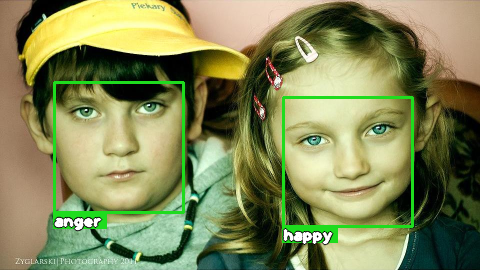

In [ ]:
Image.fromarray(img)  # CPU

In [ ]:
%%time
print('Image size: {1}x{0}'.format(*img2.shape))
img = detector.mark_faces(img2, (.25, .25), callback=annotate_facial_expressions)
# CPU

Image size: 2000x1500
CPU times: user 647 ms, sys: 12.2 ms, total: 659 ms
Wall time: 657 ms


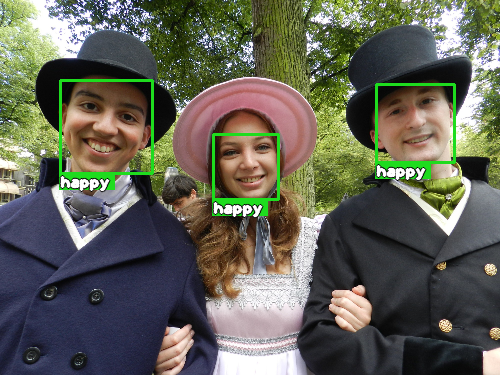

In [ ]:
Image.fromarray(img) # CPU

### GPU

In [ ]:
%%time
print('Image size: {1}x{0}'.format(*img1.shape))
img = detector.mark_faces(img1, (0.5, 0.5), callback=annotate_facial_expressions)
# GPU

Image size: 960x540
CPU times: user 110 ms, sys: 2.46 ms, total: 112 ms
Wall time: 115 ms


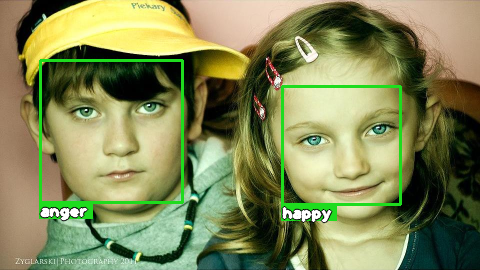

In [ ]:
Image.fromarray(img)  # GPU

In [ ]:
%%time
print('Image size: {1}x{0}'.format(*img2.shape))
img = detector.mark_faces(img2, (0.25, 0.25), callback=annotate_facial_expressions)
# GPU

Image size: 2000x1500
CPU times: user 434 ms, sys: 254 ms, total: 687 ms
Wall time: 684 ms


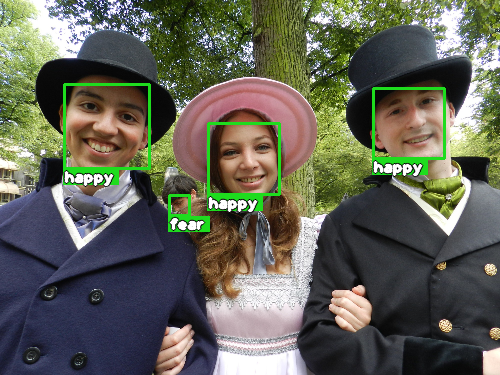

In [ ]:
Image.fromarray(img) # GPU